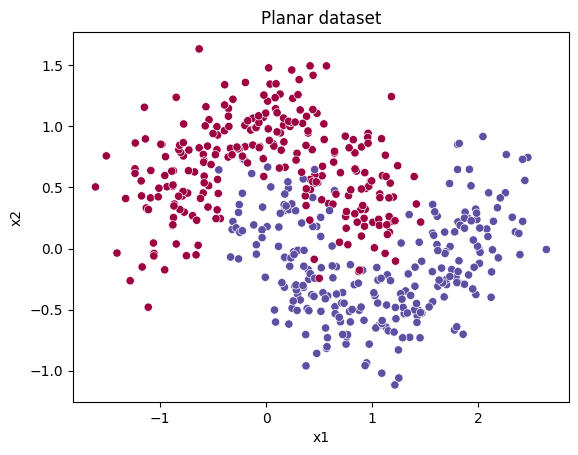

In [258]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples= 500, noise= 0.25, random_state= 42)

sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap= plt.cm.Spectral)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planar dataset")
plt.show()

In [259]:
y = y.reshape(-1, 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [260]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(a):
    return a * (1 - a)

def relu(z):
    return np.maximum(0, z)

def relu_der(z):
    return (z > 0).astype(int)

def tanh(z):
    return np.tanh(z)

def tanh_der(z):
    return 1 - np.power(np.tanh(z), 2)

In [261]:
def activation_forward(Z, activation):
    if activation == "relu":
        return relu(Z)
    elif activation == "tanh":
        return tanh(Z)
    else:
        return ValueError("Unsupported activation")
    
def activation_backward(dA, Z, activation):
    if activation == "relu":
        return dA * relu_der(Z)
    elif activation == "tanh":
        return dA * tanh_der(Z)
    else:
        return ValueError("Unsupported activation")

In [262]:
def initialize_parameters(layer_dim):
    np.random.seed(42)
    parameters = {}
    for l in range(1, len(layer_dim)):
        parameters[f"W{l}"] = np.random.randn(layer_dim[l-1], layer_dim[l])
        parameters[f"b{l}"] = np.zeros([1, layer_dim[l]])

    return parameters

In [263]:
def forward(X, parameters, activation= "relu"):
    cache = {"A0": X}
    L = len(parameters) // 2

    for l in range(1, L):
        Z = cache[f"A{l-1}"] @ parameters[f"W{l}"] + parameters[f"b{l}"]
        A = activation_forward(Z, activation)
        cache[f"Z{l}"], cache[f"A{l}"] = Z, A

    # output layer
    ZL = cache[f"A{L-1}"] @ parameters[f"W{L}"] + parameters[f"b{L}"]
    AL= sigmoid(ZL)
    cache[f"Z{L}"], cache[f"A{L}"] = ZL, AL

    return AL, cache

In [264]:
def cost_function(y_hat, y):
    m = y.shape[0]
    y_hat = np.clip(y_hat, 1e-10, 1 - 1e-10)
    return -(1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))


In [265]:
def backward(parameters, cache, y, activation= "relu"):
    grads = {}
    m = y.shape[0]
    L = len(parameters) // 2

    # output layer
    AL = cache[f"A{L}"]
    dZL = AL - y
    grads[f"dW{L}"] = cache[f"A{L-1}"].T@ dZL / m
    grads[f"db{L}"] = np.sum(dZL, axis= 0, keepdims= True) / m

    dA_prev = dZL @ parameters[f"W{L}"].T

    for l in reversed(range(1, L)):
        dZ = activation_backward(dA_prev, cache[f"Z{l}"], activation)
        grads[f"dW{l}"] = cache[f"A{l-1}"].T@ dZL / m
        grads[f"db{l}"] = np.sum(dZ, axis= 0, keepdims= True) / m
        if l > 1:
            dA_prev = dZ @ parameters[f"W{l}"].T

    return grads

In [266]:
def update(parameters, grads, alpha):
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters[f"W{l}"] -= alpha * grads[f"dW{l}"]
        parameters[f"b{l}"] -= alpha * grads[f"db{l}"]

    return parameters

def predict(X, parameters):
    y_hat, un_ = forward(X, parameters)
    return (y_hat > 0.5).astype(int)

In [267]:
def train(X, y, hidden_layers = [32, 16, 8, 4], alpha = 0.1, epochs = 1000, activation= "relu"):
    input_dims = [X.shape[1]]
    output_dims = [1]
    layer_dims = input_dims + hidden_layers + output_dims

    parameters = initialize_parameters(layer_dims)
    cost_hist = []

    for i in range(epochs):
        y_hat, cache = forward(X, parameters, activation)
        cost = cost_function(y_hat, y)
        cost_hist.append(cost)
        grads = backward(parameters, cache, y, activation)
        parameters = update(parameters, grads, alpha)

        if i % 100 == 0:
            preds = predict(X, parameters)
            acc = np.mean(preds == y) * 100
            print(f"Epoch {i} | Loss: {cost:.4f} | Train Acc: {acc:.2f}%")

    return parameters, cost_hist

In [268]:
def plot_graph(X, y, parameters):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = predict(grid, parameters).reshape(xx.shape)
    
    plt.contourf(xx, yy, preds, cmap=plt.cm.Spectral, alpha=0.6)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral, edgecolor="k")
    plt.title("Deep NN Decision Boundary")
    plt.show()

In [269]:
parameters, cost_hist = train(X_train, y_train, hidden_layers = [32, 16, 8], alpha = 0.1, epochs = 5000, activation= "relu")

Epoch 0 | Loss: 6.8168 | Train Acc: 37.25%
Epoch 100 | Loss: 0.2333 | Train Acc: 92.25%
Epoch 200 | Loss: 0.1848 | Train Acc: 93.25%
Epoch 300 | Loss: 0.1612 | Train Acc: 94.25%
Epoch 400 | Loss: 0.1498 | Train Acc: 95.75%
Epoch 500 | Loss: 0.1383 | Train Acc: 95.75%
Epoch 600 | Loss: 0.1308 | Train Acc: 95.25%
Epoch 700 | Loss: 0.1276 | Train Acc: 95.50%
Epoch 800 | Loss: 0.1251 | Train Acc: 96.25%
Epoch 900 | Loss: 0.1270 | Train Acc: 95.50%
Epoch 1000 | Loss: 0.1207 | Train Acc: 95.75%
Epoch 1100 | Loss: 0.1193 | Train Acc: 95.75%
Epoch 1200 | Loss: 0.1178 | Train Acc: 95.50%
Epoch 1300 | Loss: 0.1223 | Train Acc: 95.50%
Epoch 1400 | Loss: 0.1140 | Train Acc: 96.25%
Epoch 1500 | Loss: 0.1228 | Train Acc: 95.75%
Epoch 1600 | Loss: 0.1169 | Train Acc: 95.75%
Epoch 1700 | Loss: 0.1143 | Train Acc: 96.00%
Epoch 1800 | Loss: 0.1156 | Train Acc: 95.75%
Epoch 1900 | Loss: 0.1131 | Train Acc: 96.00%
Epoch 2000 | Loss: 0.1053 | Train Acc: 96.75%
Epoch 2100 | Loss: 0.0997 | Train Acc: 97.25%


In [270]:
print("Train accuracy:", np.mean(predict(X_train, parameters) == y_train) * 100)
print("Test accuracy:", np.mean(predict(X_test, parameters) == y_test) * 100)


Train accuracy: 96.25
Test accuracy: 92.0


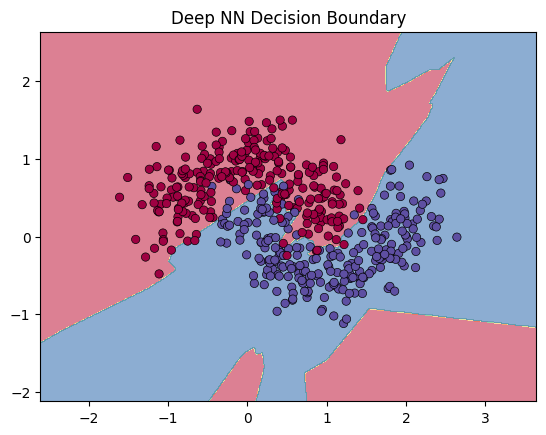

In [271]:
plot_graph(X, y, parameters)

<Axes: >

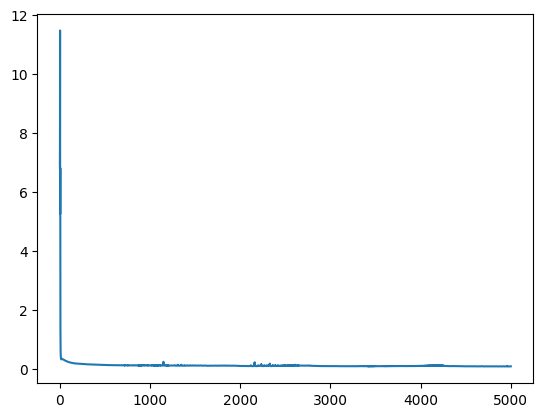

In [272]:
sns.lineplot(x= range(len(cost_hist)), y= cost_hist)

In [281]:
parameters, cost_hist = train(X_train, y_train, hidden_layers = [128, 8], alpha = 0.01, epochs = 10000, activation= "relu")

Epoch 0 | Loss: 8.7227 | Train Acc: 51.75%
Epoch 100 | Loss: 0.5543 | Train Acc: 88.50%
Epoch 200 | Loss: 0.3569 | Train Acc: 88.75%
Epoch 300 | Loss: 0.2652 | Train Acc: 89.50%
Epoch 400 | Loss: 0.2245 | Train Acc: 91.25%
Epoch 500 | Loss: 0.2003 | Train Acc: 91.75%
Epoch 600 | Loss: 0.1843 | Train Acc: 93.00%
Epoch 700 | Loss: 0.1729 | Train Acc: 93.50%
Epoch 800 | Loss: 0.1650 | Train Acc: 94.25%
Epoch 900 | Loss: 0.1592 | Train Acc: 94.00%
Epoch 1000 | Loss: 0.1546 | Train Acc: 94.25%
Epoch 1100 | Loss: 0.1510 | Train Acc: 94.25%
Epoch 1200 | Loss: 0.1478 | Train Acc: 94.50%
Epoch 1300 | Loss: 0.1451 | Train Acc: 94.50%
Epoch 1400 | Loss: 0.1426 | Train Acc: 94.75%
Epoch 1500 | Loss: 0.1402 | Train Acc: 94.75%
Epoch 1600 | Loss: 0.1379 | Train Acc: 94.75%
Epoch 1700 | Loss: 0.1350 | Train Acc: 95.00%
Epoch 1800 | Loss: 0.1324 | Train Acc: 95.50%
Epoch 1900 | Loss: 0.1304 | Train Acc: 96.00%
Epoch 2000 | Loss: 0.1287 | Train Acc: 96.00%
Epoch 2100 | Loss: 0.1271 | Train Acc: 96.00%


In [282]:
print("Train accuracy:", np.mean(predict(X_train, parameters) == y_train) * 100)
print("Test accuracy:", np.mean(predict(X_test, parameters) == y_test) * 100)

Train accuracy: 95.75
Test accuracy: 90.0


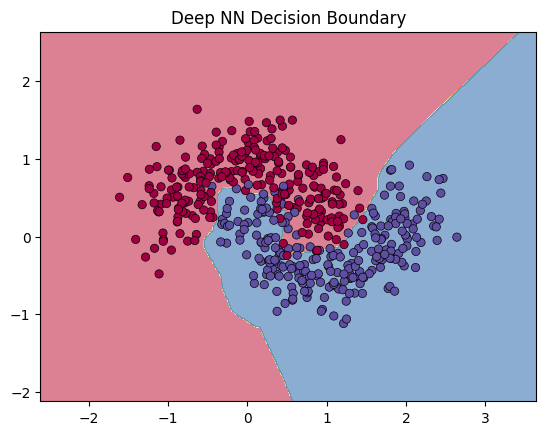

In [283]:
plot_graph(X, y, parameters)

<Axes: >

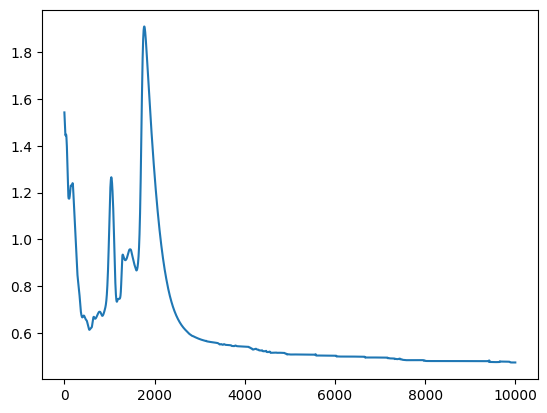

In [276]:
sns.lineplot(x= range(len(cost_hist)), y= cost_hist)